In [157]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [158]:
pathTrainData = '../html2023-spring-final-project-stage-2/html2023-spring-final-project/train.csv'
pathTestData = '../html2023-spring-final-project-stage-2/html2023-spring-final-project/test.csv'
helpTestDance = '../html2023-spring-final-project-stage-2/test_partial_answer.csv'

In [159]:
train = pd.read_csv(pathTrainData)
test = pd.read_csv(pathTestData)
partialAnswer = pd.read_csv(helpTestDance)
print(partialAnswer.shape)

(631, 2)


Join train and test in total

In [136]:
total = pd.concat((train, test), axis=0)

Merge data Danceability by id

In [183]:
total.loc[total['id'].isin(partialAnswer['id']), 'Danceability'] = partialAnswer['Danceability']

KeyError: 'id'

In [138]:
total.set_index('id', inplace= True)

In [139]:
total.drop(columns=['Uri', 'Url_youtube', 'Description', 'Title', 'Artist', 'Album', 'Track', "official_video", "Licensed"], inplace=True)

In [140]:
total.columns

Index(['Danceability', 'Energy', 'Key', 'Loudness', 'Speechiness',
       'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo',
       'Duration_ms', 'Views', 'Likes', 'Stream', 'Album_type', 'Url_spotify',
       'Comments', 'Channel', 'Composer'],
      dtype='object')

EXTRACT NUMERICAL DATA

In [141]:
totalNumerical = total.loc[:, ['Energy', 'Loudness', 'Speechiness',
       'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Views', 'Likes', 'Stream', 'Comments']]

In [142]:
totalNumerical

,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Views,Likes,Stream,Comments
id,,,,,,,,,,,,
0,0.000273,-25.176000,0.044300,0.724151,0.000062,0.000807,0.340000,83.398000,NaN,1.376220e+05,1.998137e+07,3070.0
1,0.184220,NaN,NaN,0.672221,0.910000,0.034966,0.746000,148.692000,1.848250e+05,5.190000e+03,NaN,122.0
2,NaN,-15.596000,NaN,0.667628,0.867000,0.001772,0.380000,84.899000,1.848250e+05,5.190000e+03,1.932081e+07,122.0
3,0.209585,-6.251000,0.027700,0.003796,NaN,0.001000,NaN,150.220000,2.024573e+08,9.970350e+05,3.996619e+08,24350.0
4,NaN,NaN,0.026000,0.000003,0.000467,0.002924,0.295000,97.997000,3.166880e+08,1.299086e+06,NaN,31150.0
...,...,...,...,...,...,...,...,...,...,...,...,...
23480,0.160377,-6.366894,0.045451,0.317692,0.006016,0.001642,0.160253,72.136829,9.636781e+06,5.807853e+04,1.750041e+07,168.0
23481,0.318585,-4.148566,0.073000,0.007420,0.000817,0.008843,0.614366,NaN,4.572846e+07,7.227992e+04,1.365601e+07,448.0
23482,0.426223,-5.807545,0.072906,0.661708,0.898308,0.000662,0.087281,87.969239,-3.451740e+06,2.305163e+04,1.849094e+07,NaN


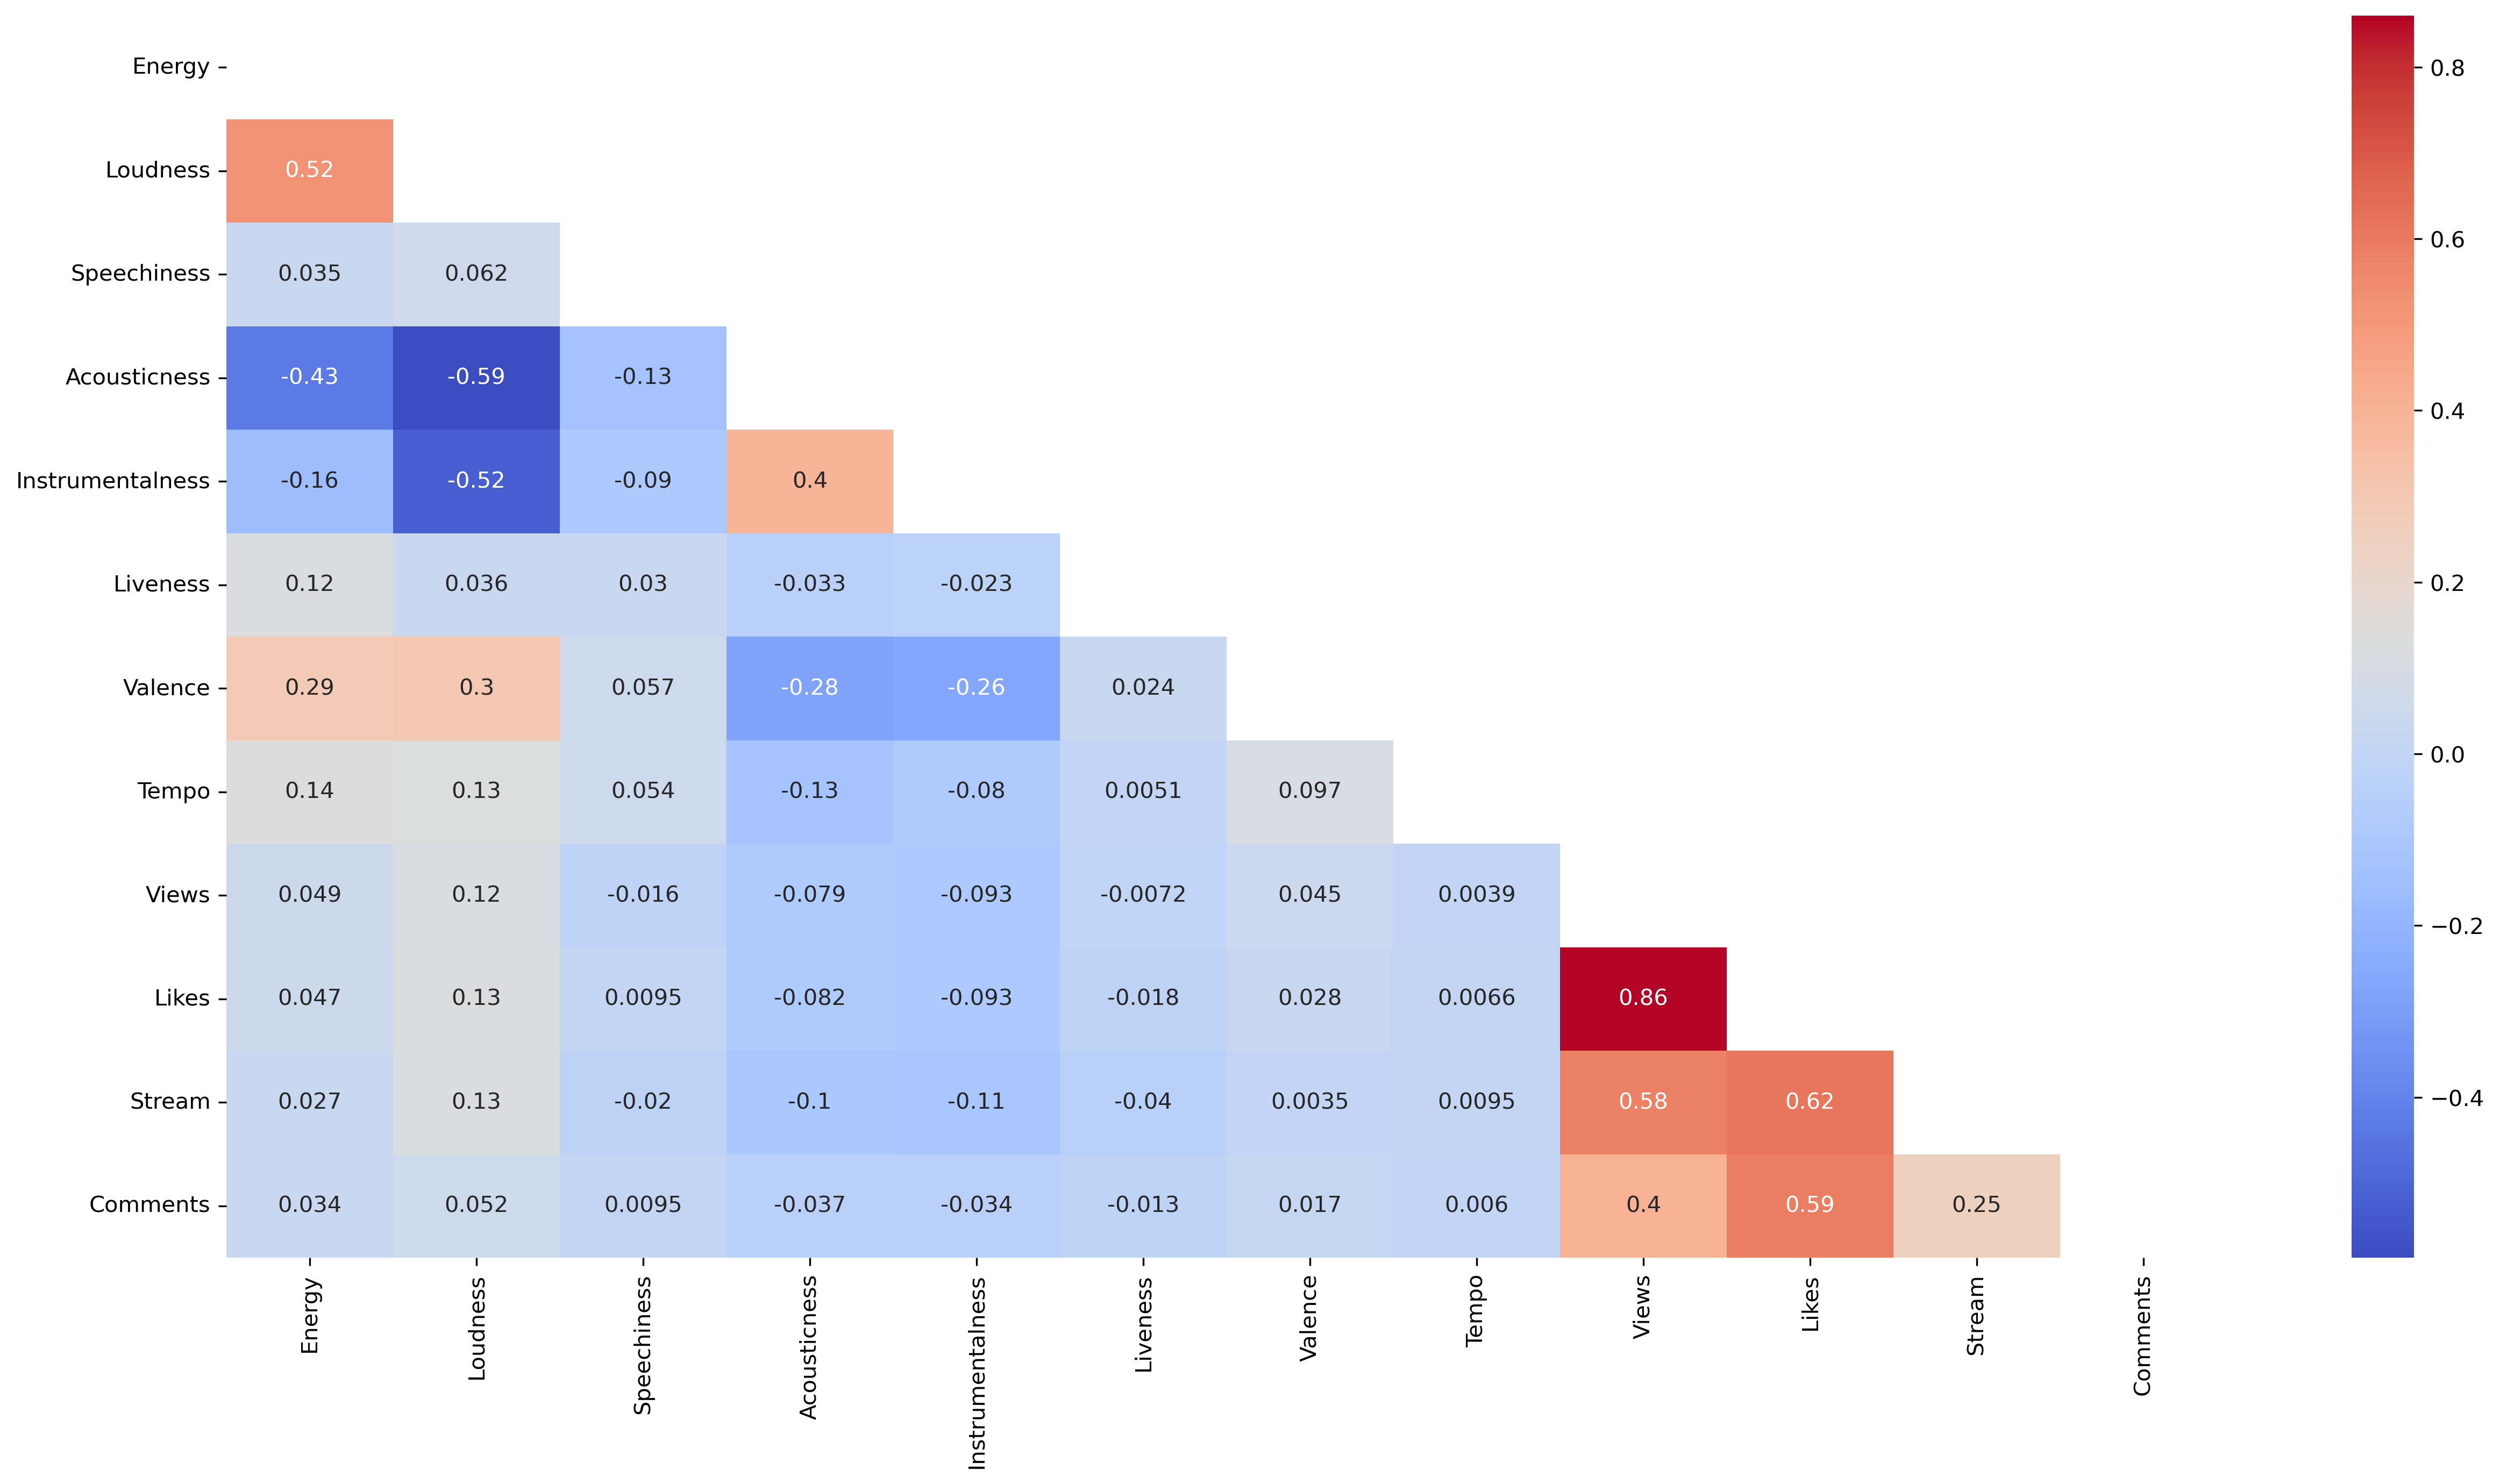

In [143]:
fig, ax = plt.subplots(figsize=(20, 10), dpi=300)
mask = np.triu(np.ones_like(totalNumerical.corr()))
dataplot = sns.heatmap(totalNumerical.corr(), cmap="coolwarm", annot=True, mask=mask)

In [144]:
totalNumerical.isnull().sum(0)

Energy              3523
Loudness            3523
Speechiness         3523
Acousticness        3523
Instrumentalness    3523
Liveness            3523
Valence             3523
Tempo               3523
Views               3523
Likes               3523
Stream              3523
Comments            3523
dtype: int64

TEST FUNCTION

In [184]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from lightgbm import train, Dataset, early_stopping

class testImputate():
    def __init__(self, data) -> None:
        self.data =  data.copy()
    
    def __parameters__(self):
        return {
            "objective":"regression",
            "boosting": "random_forest", 
            "num_iterations": 128,
            "max_depth": 8,
            "num_leaves": 128,
            "min_data_in_leaf": 1,
            "min_sum_hessian_in_leaf": 0.00001,
            "min_gain_to_split": 0.0,
            "bagging_fraction": 0.632,
            "feature_fraction": 1.0,
            "feature_fraction_bynode": 0.632,
            "bagging_freq": 1,
            "verbosity": -1,
            }


    def mice(self, n=1):
        # self.__getDataType__()
        for feature in self.data.columns:
            TrainTotalScaled_X, TrainTotal_y, X_predPD = self.preprocessing(feature)
            prediction = pd.DataFrame()
            for i in range(n):
                X_train, X_validation, y_train, y_validation = self.splitDataset(TrainTotalScaled_X, TrainTotal_y, randomState = i)
                prediction[f'pred_{i}'] = self.__model__(X_train, X_validation, y_train, y_validation, X_predPD)
            newImpute = prediction.mean(axis=1)
            prediction['prediction'] = newImpute

            prediction['id'] = X_predPD.index
            prediction = prediction.set_index('id')

            self.data[feature].update(prediction['prediction'] )


    def __model__(self, X_train, X_validation, y_train, y_validation, X_predPD):
        
        
        train_data = Dataset(X_train, label=y_train)
        validation_data = Dataset(X_validation, label=y_validation)
        bst = train(self.__parameters__(), train_data, valid_sets=[validation_data], callbacks=[early_stopping(stopping_rounds=5)])
        return bst.predict(X_predPD)


    # def __getDataType__(self):
    #     self.dataType = {}
    #     for i in self.data.columns:
    #         self.dataType[i] = self.data[i].dtype

    def scaleData(self, data):
        scaler = StandardScaler()
        scaledData = scaler.fit_transform(data)
        scaledDataPD = pd.DataFrame(scaledData, columns=data.columns)
        return scaler, scaledDataPD
    
    def splitDataset(self, dataX, dataY, randomState = 0):
        X_train, X_validation, y_train, y_validation = train_test_split(dataX, dataY, test_size=0.2, random_state=randomState)
        return X_train, X_validation, y_train, y_validation 

    def preprocessing(self, feature):
        print(f"___ Processing {feature} ___")
        auxDataCopy = self.data.copy()
        # Delete nan data from data to predict
        featurePredict = auxDataCopy[auxDataCopy[feature].isna()]
        # Data to test model
        predictData = featurePredict.loc[:, ~featurePredict.columns.isin([feature])]
        trainData = auxDataCopy.dropna(axis=0, how="any", subset=[feature])
        # Create data to train
        TrainTotal_y = trainData.loc[:, trainData.columns.isin([feature])]
        TrainTotal_X = trainData.loc[:, ~trainData.columns.isin([feature])]
        scaler, TrainTotalScaled_X = self.scaleData(TrainTotal_X)

        # Fixed ID
        TrainTotalScaled_X['id'] = TrainTotal_y.index
        TrainTotalScaled_X = TrainTotalScaled_X.set_index('id')

        # Prediceted Data Scaler
        X_pred =  scaler.transform(predictData)
        X_predPD = pd.DataFrame(X_pred, columns=predictData.columns)

        X_predPD['id'] = predictData.index
        X_predPD = X_predPD.set_index('id')

        return TrainTotalScaled_X, TrainTotal_y, X_predPD
    
    def plotCorrelation(self):
        fig, ax = plt.subplots(figsize=(20, 10), dpi=300)
        mask = np.triu(np.ones_like(self.data.corr()))
        sns.heatmap(self.data.corr(), cmap="coolwarm", annot=True, mask=mask)
        


        

        

In [179]:
t = testImputate(totalNumerical)
t.mice(2)


___ Processing Energy ___
Training until validation scores don't improve for 5 rounds


c:\Users\Miguel\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\Miguel\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[26]	valid_0's l2: 0.0307683
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[15]	valid_0's l2: 0.0315134
___ Processing Loudness ___
Training until validation scores don't improve for 5 rounds


c:\Users\Miguel\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\Miguel\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[27]	valid_0's l2: 7.00299
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[33]	valid_0's l2: 6.72023
___ Processing Speechiness ___


c:\Users\Miguel\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\Miguel\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[19]	valid_0's l2: 0.00855636
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	valid_0's l2: 0.00867221
___ Processing Acousticness ___


c:\Users\Miguel\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\Miguel\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[31]	valid_0's l2: 0.0243097
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[27]	valid_0's l2: 0.0242842
___ Processing Instrumentalness ___
Training until validation scores don't improve for 5 rounds


c:\Users\Miguel\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[40]	valid_0's l2: 0.0232411
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[36]	valid_0's l2: 0.023417
___ Processing Liveness ___


c:\Users\Miguel\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\Miguel\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\Miguel\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[16]	valid_0's l2: 0.0126258
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[14]	valid_0's l2: 0.0129348
___ Processing Valence ___


c:\Users\Miguel\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\Miguel\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[21]	valid_0's l2: 0.0449126
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[16]	valid_0's l2: 0.0448201
___ Processing Tempo ___
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[8]	valid_0's l2: 870.594
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[16]	valid_0's l2: 854.51
___ Processing Views ___


c:\Users\Miguel\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\Miguel\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\Miguel\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\Miguel\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\Miguel\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iteratio

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[6]	valid_0's l2: 2.28551e+16
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[10]	valid_0's l2: 1.85475e+16
___ Processing Likes ___
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[21]	valid_0's l2: 4.86825e+11
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[16]	valid_0's l2: 5.44753e+11
___ Processing Stream ___
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[7]	valid_0's l2: 2.83997e+16
Training until validation scores don't improve for 5 rounds


c:\Users\Miguel\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\Miguel\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\Miguel\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[16]	valid_0's l2: 3.02745e+16
___ Processing Comments ___
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[3]	valid_0's l2: 2.95914e+10
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[7]	valid_0's l2: 1.02001e+10


c:\Users\Miguel\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\Miguel\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [180]:
t.data

,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Views,Likes,Stream,Comments
id,,,,,,,,,,,,
0,0.000273,-25.176000,0.044300,0.724151,0.000062,0.000807,0.340000,83.398000,1.901622e+07,1.376220e+05,1.998137e+07,3070.000000
1,0.184220,-11.096640,0.092734,0.672221,0.910000,0.034966,0.746000,148.692000,1.848250e+05,5.190000e+03,3.875977e+07,122.000000
2,0.038405,-15.596000,0.050551,0.667628,0.867000,0.001772,0.380000,84.899000,1.848250e+05,5.190000e+03,1.932081e+07,122.000000
3,0.209585,-6.251000,0.027700,0.003796,0.009210,0.001000,0.408904,150.220000,2.024573e+08,9.970350e+05,3.996619e+08,24350.000000
4,0.315264,-6.296560,0.026000,0.000003,0.000467,0.002924,0.295000,97.997000,3.166880e+08,1.299086e+06,3.144806e+08,31150.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
23480,0.160377,-6.366894,0.045451,0.317692,0.006016,0.001642,0.160253,72.136829,9.636781e+06,5.807853e+04,1.750041e+07,168.000000
23481,0.318585,-4.148566,0.073000,0.007420,0.000817,0.008843,0.614366,118.097679,4.572846e+07,7.227992e+04,1.365601e+07,448.000000
23482,0.426223,-5.807545,0.072906,0.661708,0.898308,0.000662,0.087281,87.969239,-3.451740e+06,2.305163e+04,1.849094e+07,10206.741496


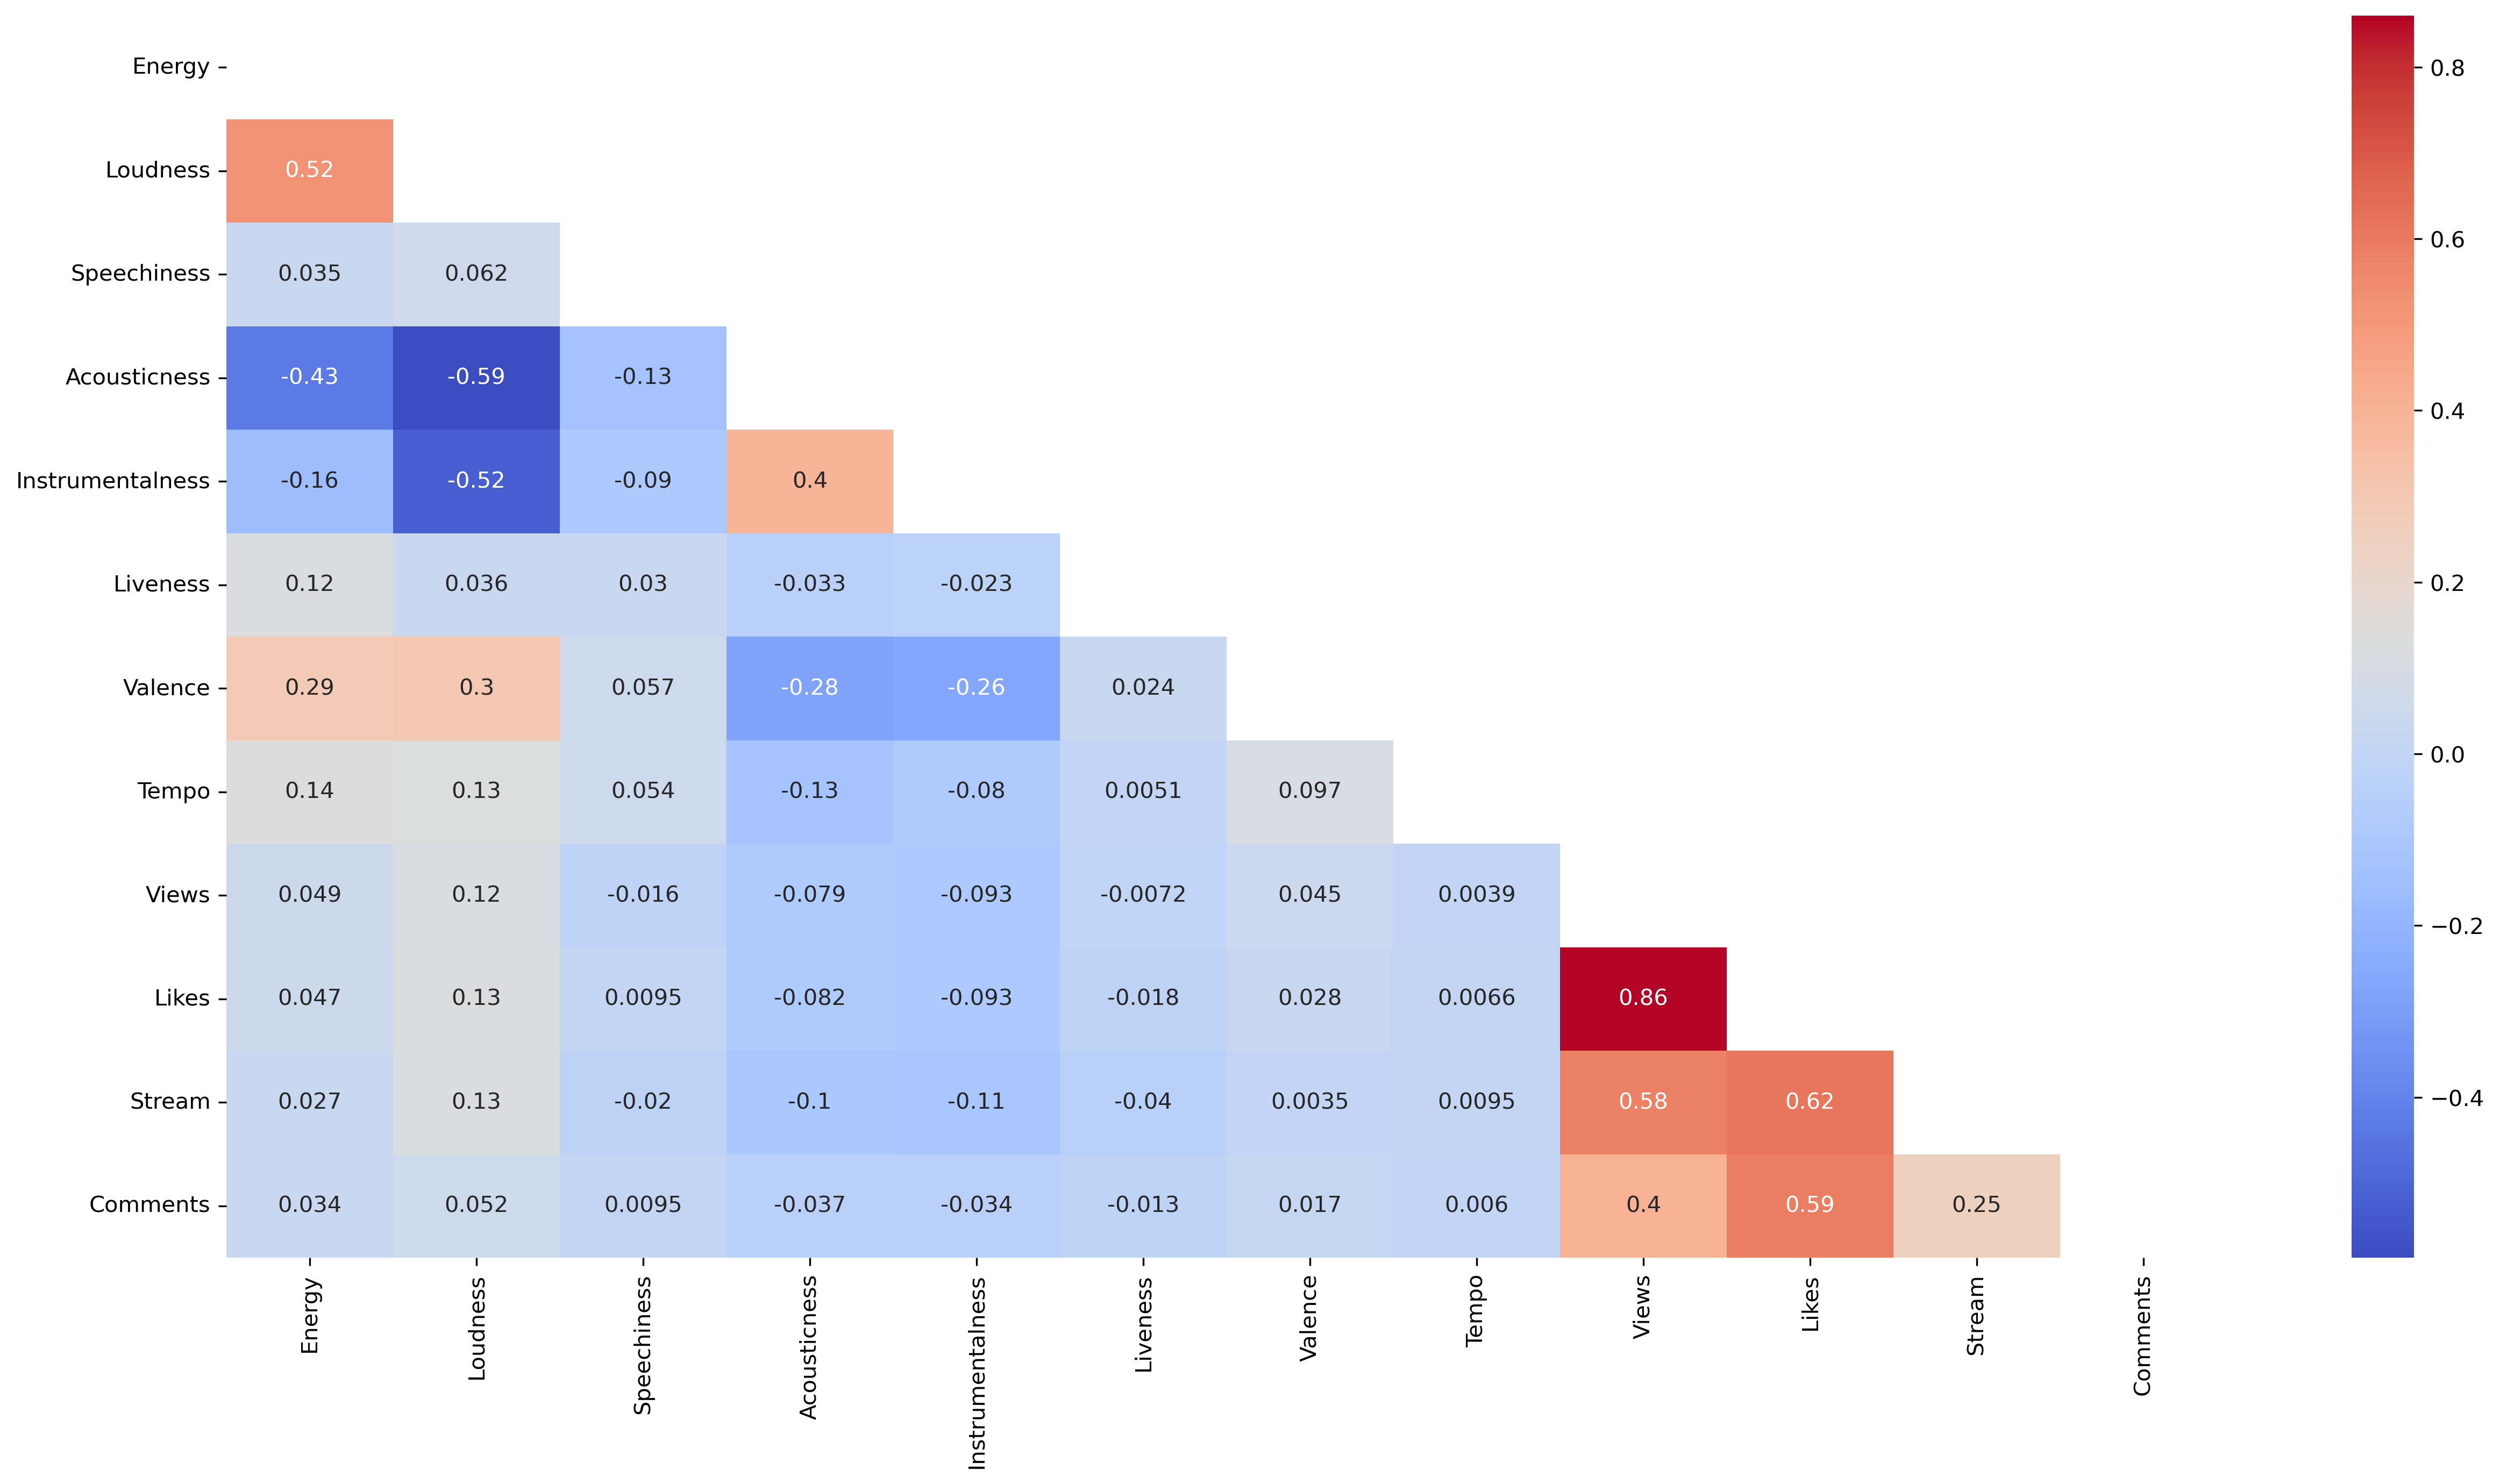

In [181]:
fig, ax = plt.subplots(figsize=(20, 10), dpi=300)
mask = np.triu(np.ones_like(totalNumerical.corr()))
dataplot = sns.heatmap(totalNumerical.corr(), cmap="coolwarm", annot=True, mask=mask)

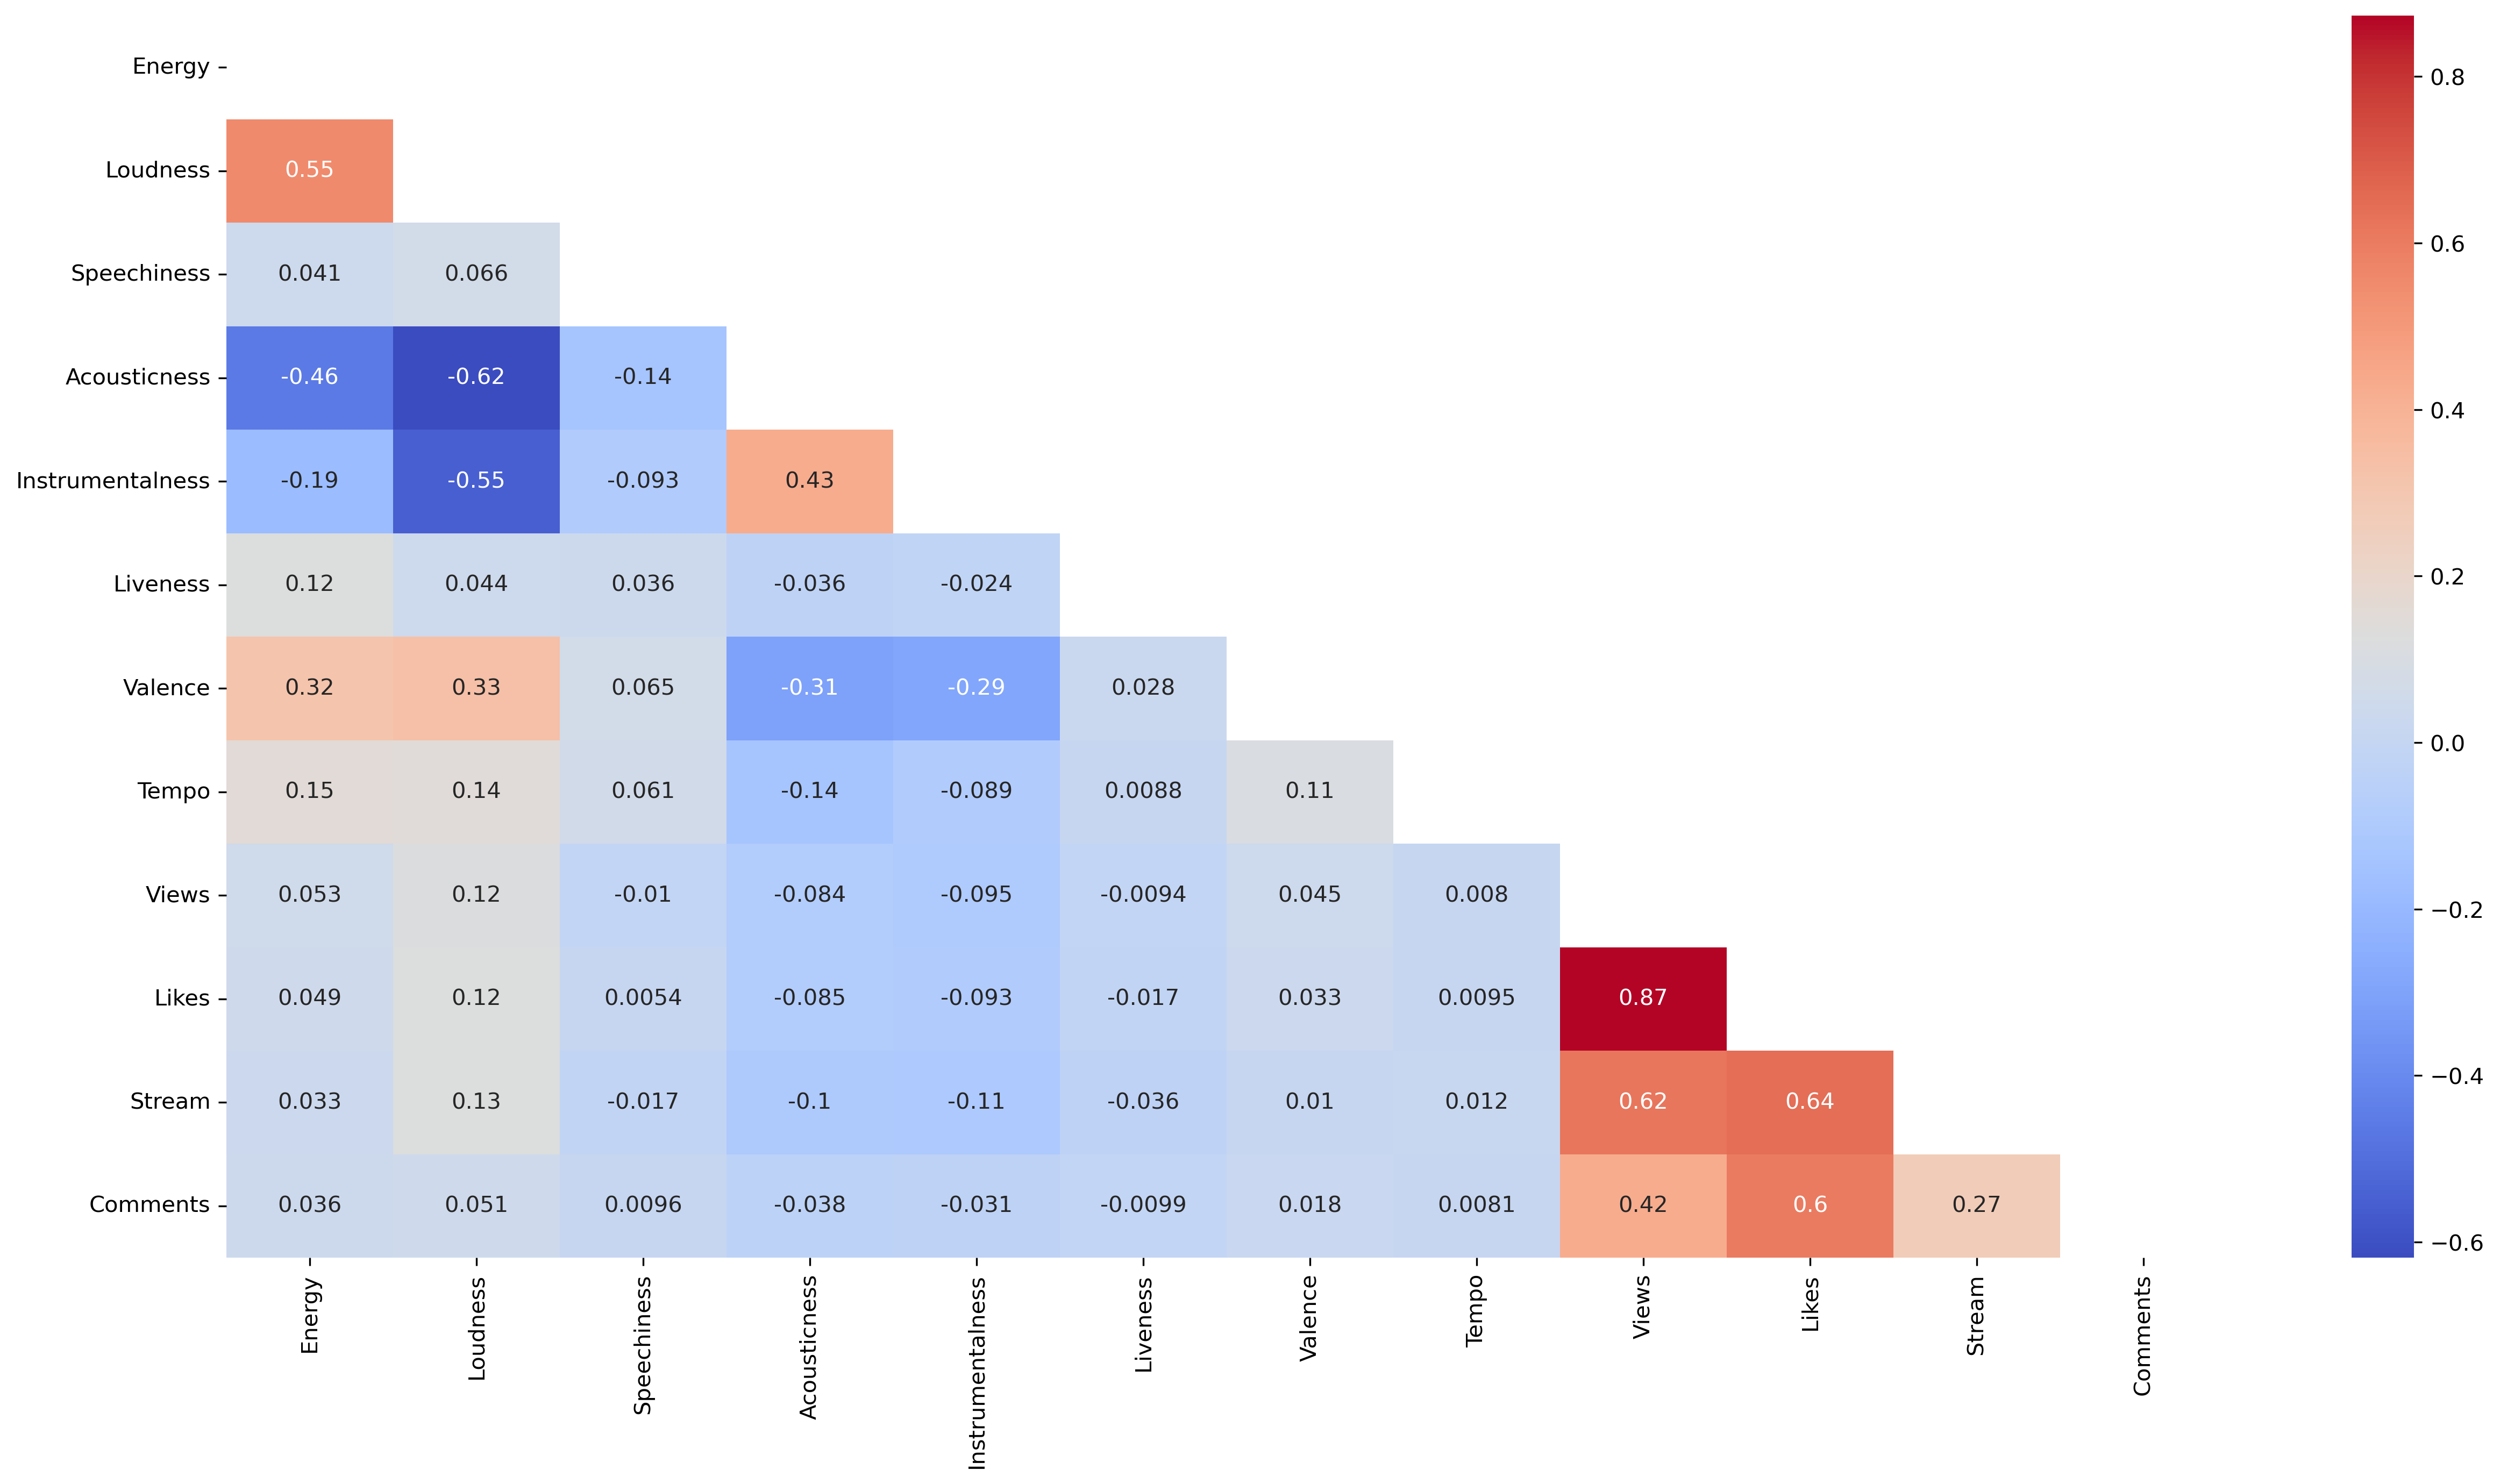

In [173]:
t.plotCorrelation()

In [182]:
t.data.isna().sum()

Energy              0
Loudness            0
Speechiness         0
Acousticness        0
Instrumentalness    0
Liveness            0
Valence             0
Tempo               0
Views               0
Likes               0
Stream              0
Comments            0
dtype: int64

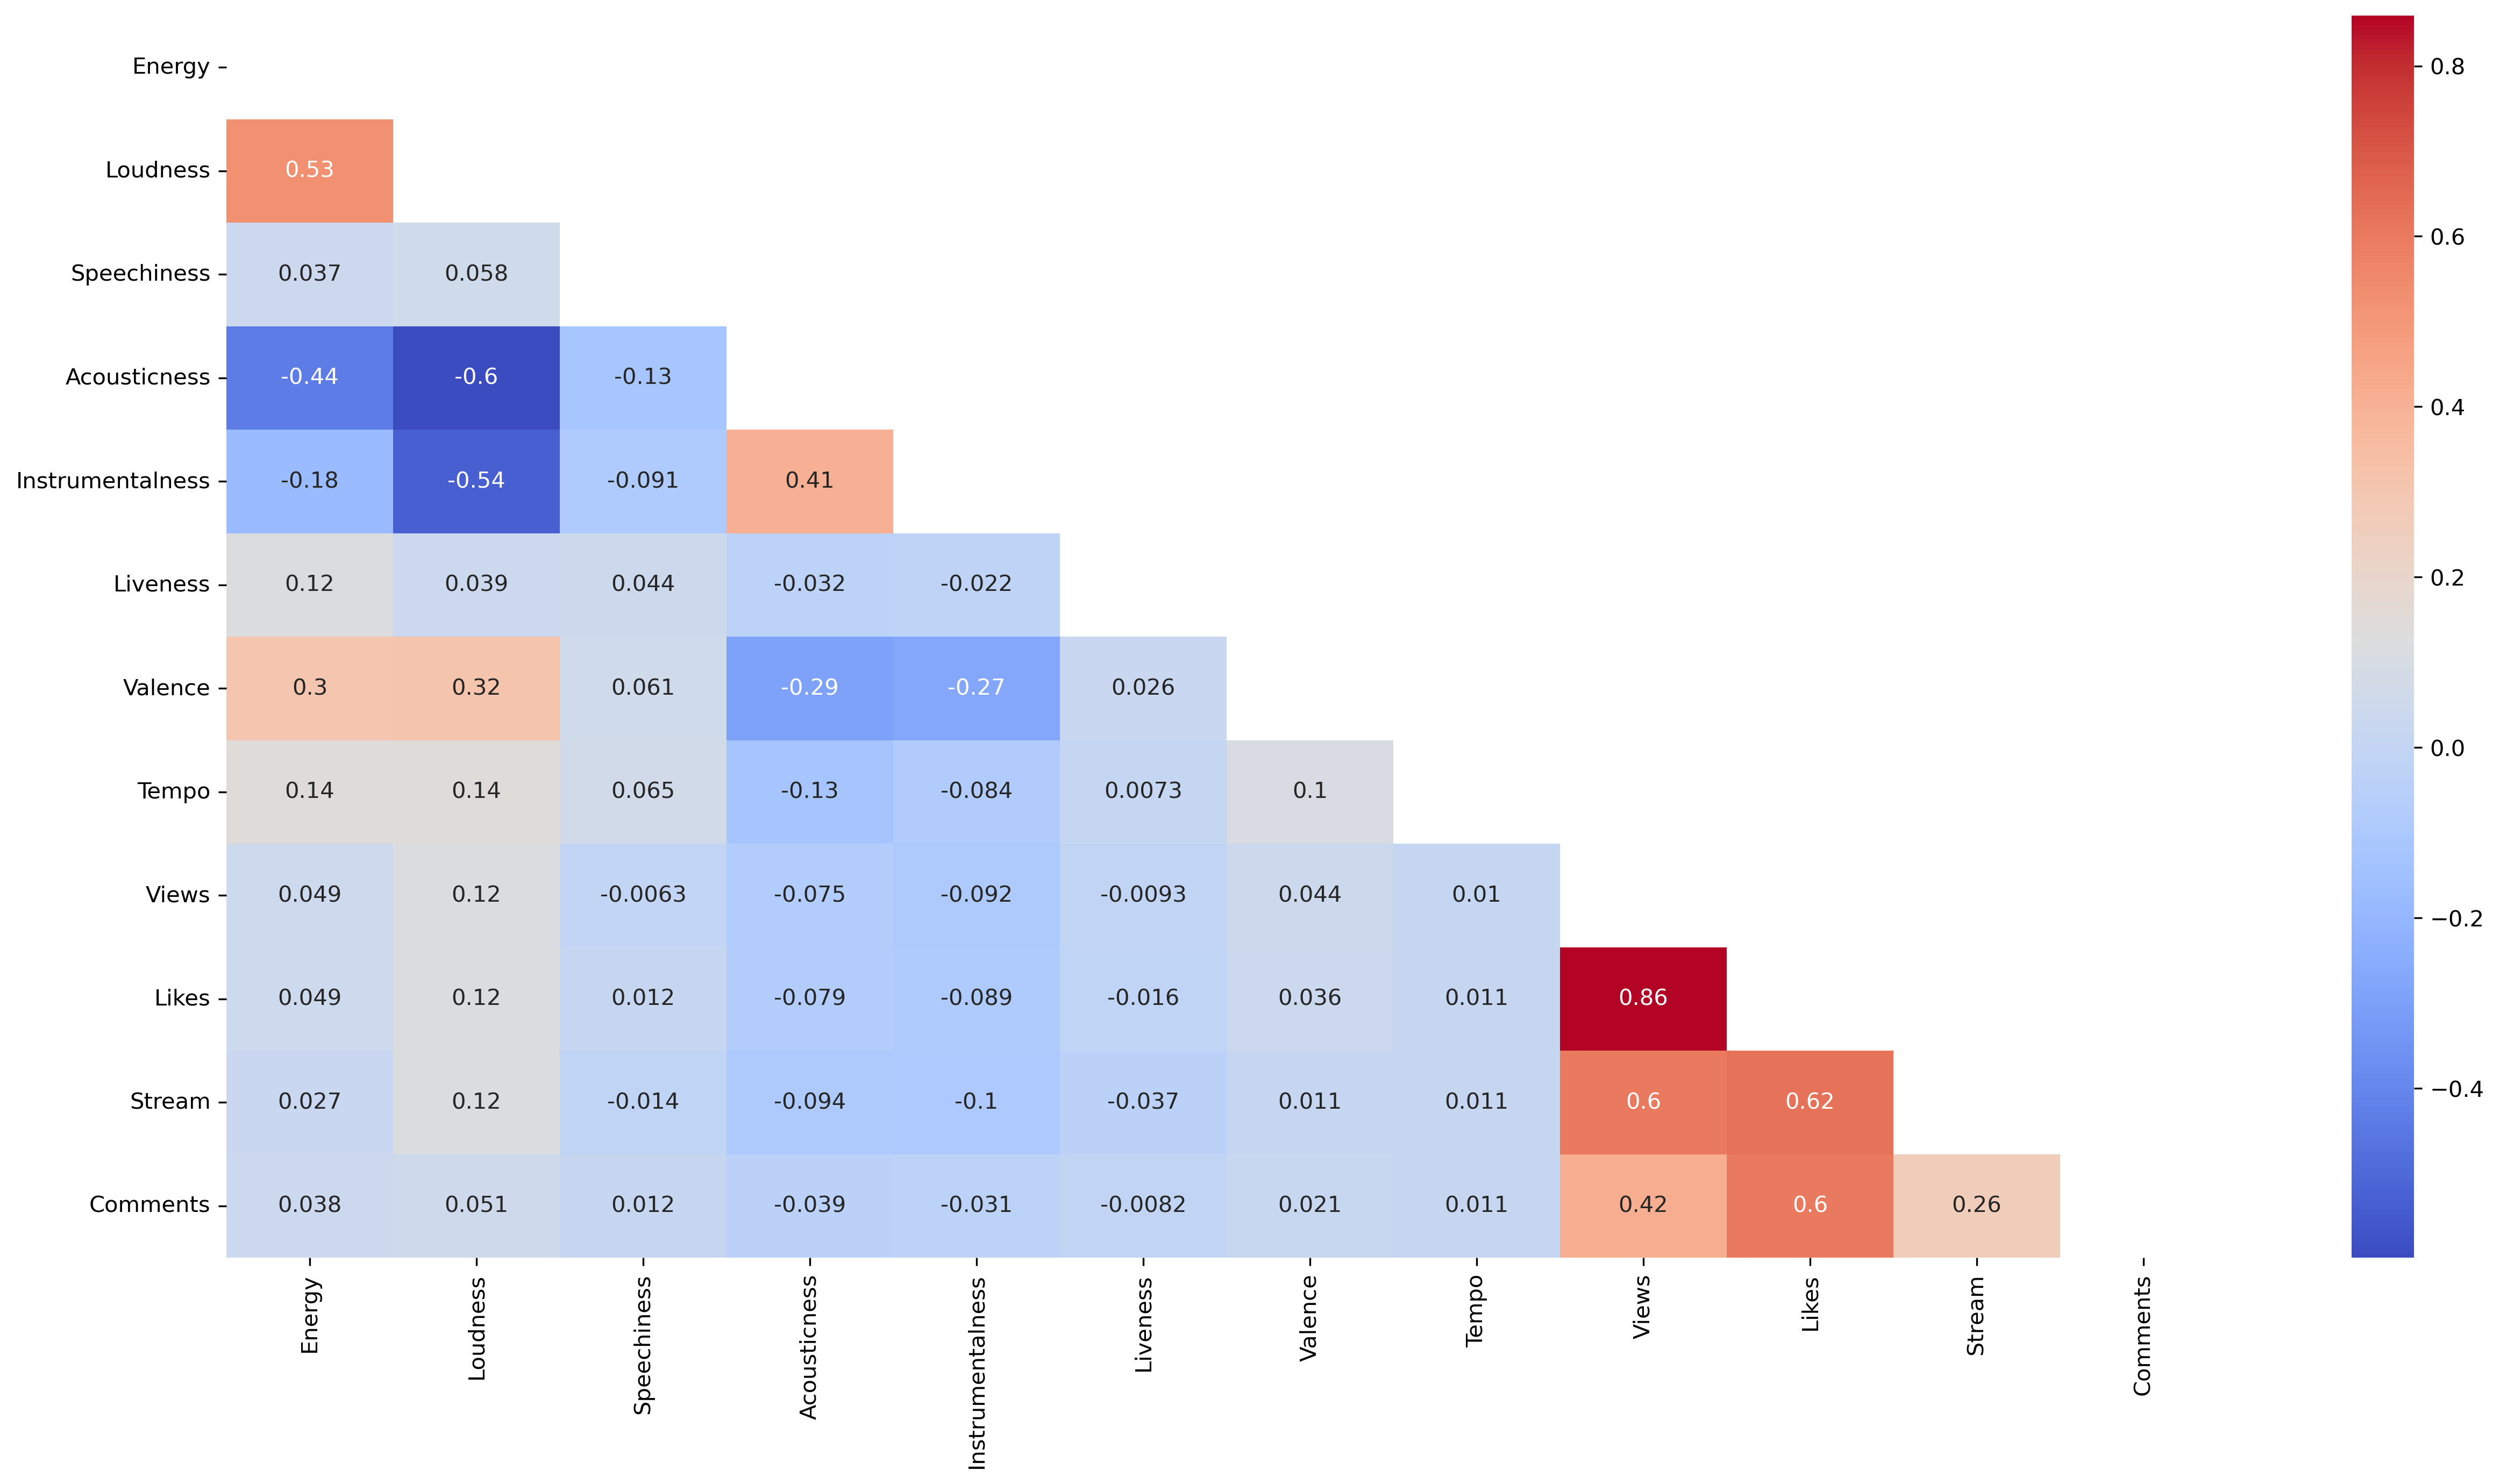

In [161]:
fig, ax = plt.subplots(figsize=(20, 10), dpi=300)
mask = np.triu(np.ones_like(totalImputationTestkds.corr()))
dataplot = sns.heatmap(totalImputationTestkds.corr(), cmap="coolwarm", annot=True, mask=mask)

In [40]:
totalImputationTestkds.isnull().sum(0)

Danceability        0
Energy              0
Key                 0
Loudness            0
Speechiness         0
Acousticness        0
Instrumentalness    0
Liveness            0
Valence             0
Tempo               0
Duration_ms         0
Views               0
Likes               0
Stream              0
Album_type          0
Url_spotify         0
Comments            0
Channel             0
Composer            0
dtype: int64